In [1]:
from random import randint, random
import numpy as np
from collections import defaultdict
from statistics import mean
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt

<img src="algorithm.PNG">

In [2]:
class Agent:
    def __init__(self):
        '''
            p - стратегия для всех состояний. 0 - "еще", 1 - "хватит"
                Состояние зависит от трех факторов (наличие играющего туза (0, 1); 
                                                    открытая карта сдающего (1-10); 
                                                    количество очков (4-21))
            Q - оценка функции ценности. Зависит от состония и действия
            returns - сохраняет доходы для каждой пары состояние-действие после каждого эпизода
            S_A - хранит информацию об эпизоде
        '''
        self.Q =  defaultdict(lambda: [0.0, 0.0])
        self.p = defaultdict(lambda: 0)
        self.returns = defaultdict(lambda: (list(), list()))
        self.S_A = []
        self.T = 0
        self.d_card = 0
    
    def start(self, card1, card2, dealer_card):
        
        self.S_A = []
        self.d_card = dealer_card
        
        # оценка туза
        if 1 in [card1, card2]:
            self.T = self.playing_T(sum([card1, card2])-1)
            
        # подсчет очков
        points = sum([card1, card2]) + self.T*10
        
        return (self.T, self.d_card, points)
    
    @staticmethod
    def playing_T(points):
        if points + 11 <= 21:
            return 1
        return 0
    
    def action(self, s):
        a = self.p[s]
        self.S_A.append((s, a))
        
        return a
        
    def state(self, points, card):
        
        # оценка туза
        if self.T == 0 and card == 1:
            self.T = self.playing_T(points)
            card += self.T*10

        #подсчет очков
        points += card

        # если перебор, то переоцениваем туза
        if points > 21 and self.T == 1:
            points -= 10
            self.T = 0
            
        return (self.T, self.d_card, points)
                    
    
    def policy_improvement(self, r, e):
        
        S_A_set = set(self.S_A) # для оценки уникальных пар состояние-действие
        for s, a in S_A_set:
            self.returns[s][a].append(r) # доход равен награде, так как обесценивание = 1, а доход зависит только от конечной награды
            self.Q[s][a] = mean(self.returns[s][a]) # средний доход для пары состояние-действие
            A = np.argmax(self.Q[s]) # отбираем лучший action 
            if random() < e: # обновляем стратегию на лучший action с вероятностью 1-е
                self.p[s] = 1-A
            else: 
                self.p[s] = A
        
        return self.p

In [3]:
class Dealer:
    def __init__(self):
        '''
            deck - бесконечная колода карт
        '''
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1] 
        self.T = 0
    
    def card(self):
        card = self.deck[randint(0,len(self.deck)-1)]
        return card
    
    @staticmethod
    def playing_T(points):
        if points + 11 <= 21:
            return 1
        return 0
    
    def start(self, card1_d, card2_d):
        
        # оценка туза
        if 1 in [card1_d, card2_d]:
            self.T = self.playing_T(sum([card1_d, card2_d])-1)
            
        # подсчет очков
        points = sum([card1_d, card2_d]) + self.T*10
        
        return points
    
    @staticmethod
    def action(points):
        # дилер берет карты пока не наберется более 17 очков включительно
        if points < 17:
            return 0
        return 1
    
    def points(self, points, card):
        
        # оценка туза
        if self.T == 0 and card == 1:
            self.T = self.playing_T(points)
            card += self.T*10

        #подсчет очков
        points += card

        # если перебор, то переоцениваем туза
        if points > 21 and self.T == 1:
            points -= 10
            self.T = 0
            
        return points
    
    @staticmethod
    def reward(points, p_dealer):
        
        if points > 21:
            return -1 
        if p_dealer > 21:
            return 1
        if points > p_dealer:
            return 1
        if points < p_dealer:
            return -1
        return 0 

In [4]:
agent = Agent()
dealer = Dealer()
e = 0.3

In [5]:
for _ in tqdm(range(500000)):
    card1_d = dealer.card()
    card2_d = dealer.card()
    card1_a = dealer.card()
    card2_a = dealer.card()
    s = agent.start(card1_a, card2_a, card1_d)
    d_points = dealer.start(card1_d, card2_d)
    points = s[2]
    a = agent.action(s)
    while a == 0:
        card = dealer.card()
        s = agent.state(points, card)
        points = s[2]
        if points > 21:
            break
        a = agent.action(s)
    if a == 1:
        d_a = dealer.action(d_points)
        while d_a == 0:
            card = dealer.card()
            d_points = dealer.points(d_points, card)
            d_a = dealer.action(d_points)
    r = dealer.reward(points, d_points)
    p = agent.policy_improvement(r, e=e)

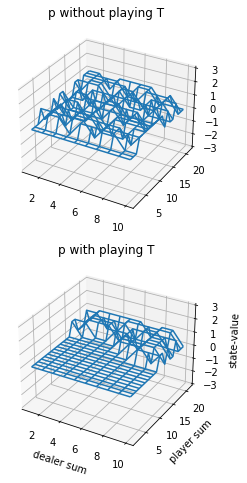

In [6]:
def plot_blackjack(V, ax1, ax2):
    points = np.arange(2, 21 + 1)
    dealer_card = np.arange(1, 10 + 1)         
    playing_T = np.array([0, 1])
    state_values = np.zeros((len(playing_T), len(dealer_card), len(points)))
    for i, T in enumerate(playing_T):
        for j, card in enumerate(dealer_card):
            for k, p in enumerate(points):
                state_values[i, j, k] = V[T, card, p]
    Y, X = np.meshgrid(points, dealer_card)
    ax1.plot_wireframe(X, Y, state_values[0, :, :])   
    ax2.plot_wireframe(X, Y, state_values[1, :, :])
    for ax in ax1, ax2:    
        ax.set_zlim(-3, 3)
    ax.set_xlabel("dealer sum")
    ax.set_ylabel("player sum")
    ax.set_zlabel("state-value")
fig, axes = plt.subplots(nrows=2, figsize=(5, 8),subplot_kw={'projection': '3d'})
axes[0].set_title('p without playing T')
axes[1].set_title('p with playing T')
plot_blackjack(p, axes[0], axes[1])